# Steps and Tasks

## 1. Import and analyse the data set.

● Exploring the given Data files

● Understanding the structure of data

● Missing points in data - description null 

● Finding inconsistencies in the data - class imbalance ; Number of words in ticket desc less 

In [1]:
import pandas as pd # read data file, data processing
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting graph for EDA , Metrics analysis
%matplotlib inline
import seaborn as sns # plotting graph for EDA , Metrics analysis

### Load the data 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = "/content/drive/MyDrive/AIML/projects/Capstone-NLP-Ticketing/"
#data_file_name = 'input_data.xlsx'
# Input data files has been processed for 
# 1. carriage return characters like '_x000D_' and \n 
# 2. Accented encoding character like äº§å“æ‰€åœ¨ä»“åº“å‡ºé”™ã€ , è¿žæŽ¥åŽè‡ªåŠ¨æ–­å¼€ï¼Œæ
# 3. Translation of words in non english language especially German, Italian, French
# Above 3 steps are done separately and output from these steps are used for further processing
data_file_name='input_data_trans.csv'
data_file_path = data_dir+data_file_name
data_file_path

'/content/drive/MyDrive/AIML/projects/Capstone-NLP-Ticketing/input_data_trans.csv'

In [4]:
#df_data = pd.read_excel(data_file_path)
df_data = pd.read_csv(data_file_path)

In [5]:
df_data['Short description'] = df_data['Translated_ShortDesc']
df_data['Description'] = df_data['Translated_Description']

### Exploring the given Data files &  Understanding the structure of data

In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Short description       8451 non-null   object
 1   Description             8473 non-null   object
 2   Caller                  8500 non-null   object
 3   Assignment group        8500 non-null   object
 4   orig_desc               8499 non-null   object
 5   orig_short_desc         8492 non-null   object
 6   Lang                    8500 non-null   object
 7   Translated_ShortDesc    8451 non-null   object
 8   Translated_Description  8473 non-null   object
dtypes: object(9)
memory usage: 597.8+ KB


**Dataset has 8500 records** ; Not big

Short Description and Description are input features and Assignment group is Predictors / Target variables

Dataset has IT issues from users and having more of  IT related terms 

### Target Variable Analysis

In [7]:
df_assign_group = pd.DataFrame(df_data['Assignment group'].value_counts())

In [8]:
df_assign_group

,Assignment group
GRP_0,3976
GRP_8,661
GRP_24,289
GRP_12,257
GRP_9,252
...,...
GRP_64,1
GRP_67,1
GRP_35,1
GRP_70,1


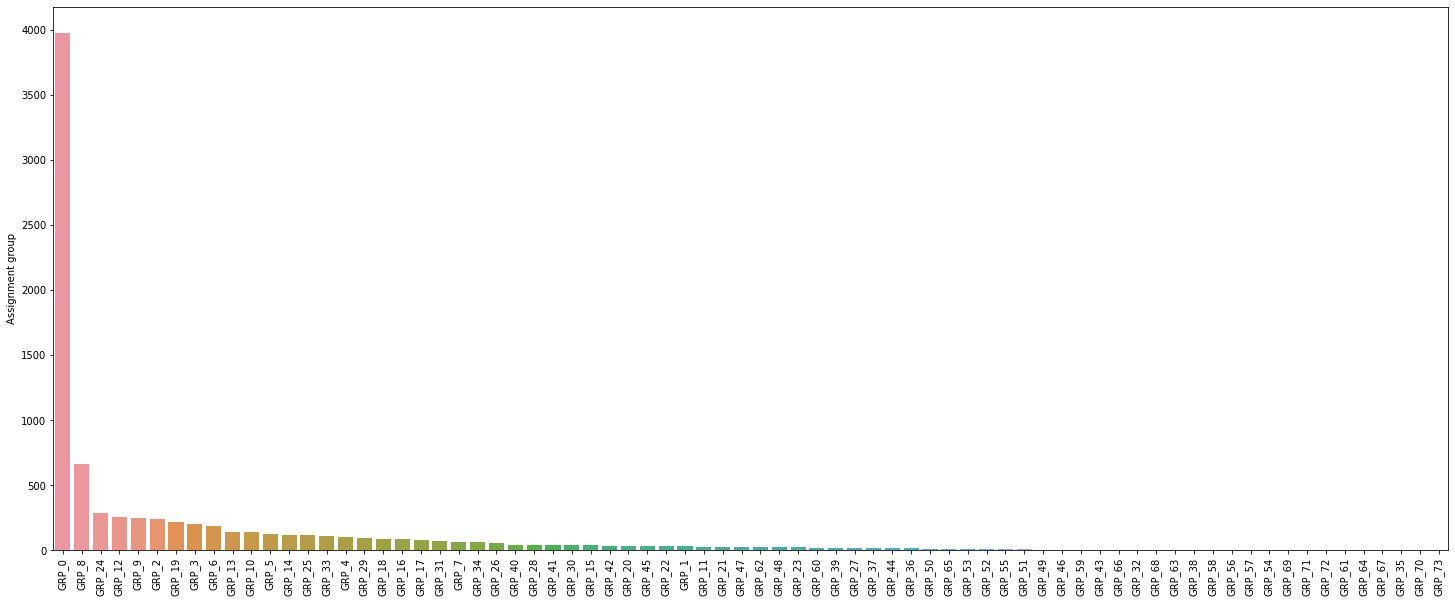

In [9]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(25, 10))
# Count plot for Assignment group 
chart = sns.barplot(y='Assignment group',x=df_assign_group['Assignment group'].index, data=df_assign_group, order=df_assign_group['Assignment group'].index, ax=ax )
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

Number of assignment group - 74

Data is highly imbalanced
  Group 0 has close to 4000 records (50% of the data) while there are many groups with less than 10 rows 

**Move all the Group with less than 10 rows to Group others** 

In [10]:
df_data['orig_assign_group'] = df_data['Assignment group']

In [11]:
df_assign_group_lt10 = df_assign_group[df_assign_group['Assignment group'] < 10]

In [12]:
df_assign_group_lt10

,Assignment group
GRP_52,9
GRP_55,8
GRP_51,8
GRP_49,6
GRP_46,6
GRP_59,6
GRP_43,5
GRP_66,4
GRP_32,4
GRP_68,3


In [13]:
#Move all the Group with less than 10 rows to Group others
df_data['Assignment group'] = df_data['Assignment group'].apply( lambda x: 'GRP_Other' if x in df_assign_group_lt10.index else x)


In [14]:
# Number of assignment groups - classes
print(df_data['Assignment group'].value_counts())
print('\nNumber of assignment group (classes) ', len(df_data['Assignment group'].value_counts()))

GRP_0        3976
GRP_8         661
GRP_24        289
GRP_12        257
GRP_9         252
GRP_2         241
GRP_19        215
GRP_3         200
GRP_6         184
GRP_13        145
GRP_10        140
GRP_5         129
GRP_14        118
GRP_25        116
GRP_33        107
GRP_4         100
GRP_29         97
GRP_18         88
GRP_Other      87
GRP_16         85
GRP_17         81
GRP_31         69
GRP_7          68
GRP_34         62
GRP_26         56
GRP_40         45
GRP_28         44
GRP_41         40
GRP_30         39
GRP_15         39
GRP_42         37
GRP_20         36
GRP_45         35
GRP_22         31
GRP_1          31
GRP_11         30
GRP_21         29
GRP_47         27
GRP_23         25
GRP_62         25
GRP_48         25
GRP_60         20
GRP_39         19
GRP_27         18
GRP_37         16
GRP_44         15
GRP_36         15
GRP_50         14
GRP_53         11
GRP_65         11
Name: Assignment group, dtype: int64

Number of assignment group (classes)  50


### Dealing with missing values

In [15]:
# Get unique values for each feature value along with Null check, find category values
# Show_levels - if True provide details of unique values 
def summarize_features(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[c,df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Column','No. of Unique values', 'uniq_val_count', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]

df_summarize_features = summarize_features(df_data[['Short description', 'Description', 'Assignment group']],True)
df_summarize_features

,Column,No. of Unique values,uniq_val_count,No. of Missing Values
Short description,Short description,"[login issue, outlook, cant log in to vpn, una...",7395,49
Description,Description,[-verified user details.(employee# & manager n...,7756,27
Assignment group,Assignment group,"[GRP_0, GRP_1, GRP_3, GRP_4, GRP_5, GRP_6, GRP...",50,0


**Number of missing values is less, but need to do text processing and check if there are any empty descriptions after cleaning up words (data pre-processing)**

In [16]:
# missing value treatment 
cond1 = df_data['Short description'].isnull()
cond2 = df_data['Description'].isnull()
df_missing = df_data[ cond1 | cond2 ]
df_missing[['Short description', 'Description', 'Assignment group', 'Lang']]

,Short description,Description,Assignment group,Lang
1081,NaN,"""""",GRP_48,en
1178,NaN,NaN,GRP_30,en
1452,NaN,NaN,GRP_30,en
1568,NaN,163crmvpnethics,GRP_31,en
1700,NaN,NaN,GRP_48,en
1701,NaN,NaN,GRP_48,en
1704,NaN,NaN,GRP_48,en
1710,NaN,St6 P-100 / + 325 16-9-16,GRP_48,no
1711,NaN,NaN,GRP_48,en
1954,NaN,NaN,GRP_30,en


In [17]:
# Replace Null description with Short description
df_data['Description'].fillna(df_data['Short description'], inplace=True)

In [18]:
# Replace Null Short description with Description
df_data['Short description'].fillna(df_data['Description'], inplace=True)

In [19]:
# Check if both Description are null, remove those records
print("No of tickets with no descriptions ", len(df_data[ cond1 & cond2 ]))

# df_data[ cond1 & cond2 ][['Short description', 'Description', 'Assignment group', 'Lang']]

No of tickets with no descriptions  27


In [20]:
df_data.drop(index = df_data[ cond1 & cond2 ].index, inplace=True, axis=0)

In [21]:
df_data.shape

(8473, 10)

#### Pre-process data
 Data is preprocessed again to remove non english characters and remove unwanted spaces

In [22]:
import re

def preprocess_text(df_column):
  # convert column to string
  df_column=df_column.apply(str)
  # Select only alphabets
  df_column = df_column.apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))
  # Convert text to lowercase
  df_column = df_column.apply(lambda x: x.lower())
  # Strip unwanted spaces
  df_column = df_column.apply(lambda x: x.strip())

  return df_column

#Apply pre process function on Short decription  & Description column
df_data['Short description'] = preprocess_text(df_data['Short description'])
df_data['Description'] = preprocess_text(df_data['Description'])

#### Check for Empty strings after pre-process in both description column and remove rows if both are empty

In [23]:
cond_1 = df_data['Description'].str.len() == 0
cond_2 = df_data['Short description'].str.len() == 0
#df_data[ & ]

In [24]:
# Check if both Description are empty, remove those records
df_data.drop(index = df_data[ cond_1 & cond_2 ].index, inplace=True, axis=0)

In [25]:
df_data.shape

(8467, 10)

In [26]:
df_data[ cond_1 | cond_2 ][['Short description', 'Description', 'Assignment group', 'Lang']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Short description,Description,Assignment group,Lang
2975,,received from yzbjhmpw vzrulkog gmail com cid ...,GRP_0,de
3010,,kg kg,GRP_48,tl
3303,,received from ktghvuwr uwtakcmj gmail com hell...,GRP_31,en
5013,,received from apacjun zhang company com hello ...,GRP_29,en
5464,,received from wqzarvhx hfsojckw gmail com hi h...,GRP_13,en
5491,,vpn,GRP_31,sl
6253,in the inbox always show there are several ema...,,GRP_0,en
6371,authorization add delete members,,GRP_0,en
7397,browser issue,,GRP_0,en
8266,erp,,GRP_30,en


In [27]:

desc_is_empty = (df_data['Description'].str.len() == 0)
df_data.loc[desc_is_empty, 'Description'] = df_data.loc[desc_is_empty, 'Short description']


short_desc_is_empty = (df_data['Short description'].str.len() == 0)
df_data.loc[short_desc_is_empty, 'Short description'] = df_data.loc[short_desc_is_empty, 'Description']

In [28]:
df_data[ cond_1 | cond_2 ][['Short description', 'Description', 'Assignment group', 'Lang']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Short description,Description,Assignment group,Lang
2975,received from yzbjhmpw vzrulkog gmail com cid ...,received from yzbjhmpw vzrulkog gmail com cid ...,GRP_0,de
3010,kg kg,kg kg,GRP_48,tl
3303,received from ktghvuwr uwtakcmj gmail com hell...,received from ktghvuwr uwtakcmj gmail com hell...,GRP_31,en
5013,received from apacjun zhang company com hello ...,received from apacjun zhang company com hello ...,GRP_29,en
5464,received from wqzarvhx hfsojckw gmail com hi h...,received from wqzarvhx hfsojckw gmail com hi h...,GRP_13,en
5491,vpn,vpn,GRP_31,sl
6253,in the inbox always show there are several ema...,in the inbox always show there are several ema...,GRP_0,en
6371,authorization add delete members,authorization add delete members,GRP_0,en
7397,browser issue,browser issue,GRP_0,en
8266,erp,erp,GRP_30,en


In [29]:
df_data.to_csv("/content/drive/MyDrive/AIML/projects/Capstone-NLP-Ticketing/input_data_trans_preprocess.csv", index=False)

In [30]:
print("Pre-processing & Target variable reassign completed")

Pre-processing & Target variable reassign completed
